In [3]:
import logging
logging.getLogger('trimesh').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('matplotlib').setLevel(logging.CRITICAL)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pvtrace import *

# Materials

In *pvtrace* material must have a refractive index,

```python
air = Material(refractive_index=1.0)
plastic = Material(refractive_index=1.5)
```

Multiple **components** can be added to materials to change the optical properties of the *volume*.

There are three components types available: absorber, scatterer, luminophore.

#### Absorber

The `Absorber` uses the Beer-Lambert law, $I = I_o e^{-\alpha x}$ to determine the propability that rays are non-radiatively absorbed as they travel along a path. Here the `coefficient` parameter it the absorption coefficient per unit length $\alpha$.

```python
opaque = Material(
    refractive_index=1.5
    components=[
        Absorber(coefficient=10.0)  # cm-1
    ]
)
```

The `components` attribute is a `list` of optical properties within the materials volume, such as absorption of light using the `Absorber` component type.

#### Scatterer

Change to `Scatterer` for a material which volume scatters light,

```python
opaque = Material(
    refractive_index=1.5
    components=[
        Scatterer(
            coefficient=1.0,  # e.g. units: cm-1
            quantum_yield=1.0
       )
    ]
)
```

The scattering coefficient is per unit length. To make scattering events non-radiative using the `quantum_yield` keyword. Scattering is assumed to be `isotropic`, change the phase function for different behaviour,

```python
opaque = Material(
    refractive_index=1.5
    components=[
        Scatterer(
            coefficient=1.0, # cm-1
            quantum_yield=1.0,
            phase_function=lambda : henyey_greenstein(g=0.8),
        )  
    ]
)
```

Henyey-Greenstein is a useful one-parameter phase function which moves between favoring back scattering (g < 0.0), isotropic (g = 0.0) and forward scattering (g > 0.0).


#### Luminophore

*pvtrace* trace was originally designed for the study of luminescent solar concentrators, in which organic dyes or nanocrystals (luminophores) are embedded in plastic sheets. They absorb rays and (possibly) remit them at longer wavelength. To use the `Lumiophore` component you will need to provide an absorption and emission spectrum.


```python

# Arrays of data
absorption_spectrum = ...  # like np.column_stack((x, y)), spectrum cm-1 nm-1
emission_spectrum = ...  # as above, spectrum nm-1

opaque = Material(
    refractive_index=1.5
    components=[
        Luminophore(
            coefficient=absorption_spectrum,
            emission=emission_spectrum,
            quantum_yield=1.0
            phase_function=isotropic  # can also have phase functions
        )
    ]
)
```

---
**Units**

*pvtrace* does *not* assume units, they could be metres, kilometres or lightyears. But you **must** pick one. Define absorption and scattering coefficient as inverses of the same unit that defines the dimensions of objects in the scene. For example, if the scene is defined in units of $\textit{cm}$ then attenuation coefficients should be $\textit{cm}^{\textit{-1}}$.

**Using experimental data**

Don't use experimental absorption coefficient data directly with *pvtrace*. For best results fit an equation to the long wavelength tail of the absorption and use a combination of real data (at short wavelength) and the fit (at long wavelengths).

---

## Example with luminescent materials

*pvtrace* comes with a default spectrum of the dye Lumogen F Red,

```python
from pvtrace.data import lumogen_f_red_305
```

Use the `absorption` and `emission` functions,


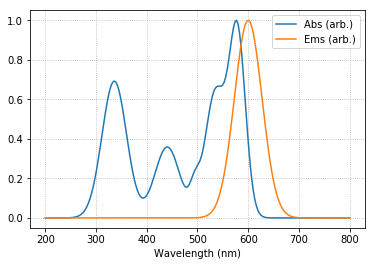

In [7]:
x = np.linspace(200, 800, 200)  # wavelength, units: nm
absorption_spectrum = lumogen_f_red_305.absorption(x)  # units: nm-1
emission_spectrum = lumogen_f_red_305.emission(x)      # units: nm-1
plt.plot(x, absorption_spectrum, label="Abs (arb.)")
plt.plot(x, emission_spectrum, label="Ems (arb.)")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.grid(linestyle="dotted")

The absorption spectrum is normalised to one so that it is easy to convert to unit you wish. Let's say units of length is now in centimetres as we construct the scene.

In [30]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Material(refractive_index=1.0)
    )
)

sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=Material(
            refractive_index=1.5,
            components=[
                Luminophore(
                    coefficient=np.column_stack((x, absorption_spectrum)),
                    emission=np.column_stack((x, emission_spectrum)),
                    quantum_yield=1.0,
                    phase_function=isotropic
                ),
                Absorber(coefficient=0.1)
            ]
        ),
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=555.0
)
scene = Scene(world)
np.random.seed(0)
vis = MeshcatRenderer(wireframe=True)
vis.render(scene)
for _ in range(10):
    steps = photon_tracer.follow(scene, ray)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7016/static/


Multiple components can be added simultaneously,

```python
components=[
    Luminophore(
        coefficient=np.column_stack((x, absorption_spectrum)),
        emission=np.column_stack((x, emission_spectrum)),
        quantum_yield=1.0,
        phase_function=isotropic
    ),
    Absorber(coefficient=0.1)
]
```

this material simulates and radiative and non-radiative absorption. For example, non-radiative absorption occurs in the host material of glass of PMMA. Non-radiative absorption by the luminophore itself can be include by reducing the `quantum_yield` keyword.

What happened above:

* The green ray enters the luminophore sphere. One ray refracts as it exists, unabsorbed (it still remains green).

* Other rays are absorbed an remitted at longer (orange) wavelengths and eventually escape.

* One ray is emitted into a trapped optical mode (red).